In [134]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

""" DL imports """

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [135]:
ct_path = "/home/jtabalon/airway_seg/test_data/ct_patients10004O.nii"
aw_path = "/home/jtabalon/airway_seg/test_data/aw_10004O.nii"

img = nib.load(ct_path).get_fdata() / 2000.
mask = nib.load(aw_path).get_fdata()

test_img = np.expand_dims(np.expand_dims(img, -1), 0)
test_mask = np.expand_dims(np.expand_dims(mask, -1), 0)

print(img.shape, mask.shape, type(img), type(mask))

(512, 512, 662) (512, 512, 662) <class 'numpy.ndarray'> <class 'numpy.memmap'>


In [136]:
print(test_img.shape, test_mask.shape)

(1, 512, 512, 662, 1) (1, 512, 512, 662, 1)


In [137]:
# 0 -> patient
# 1 -> row
# 2 -> column
# 3 -> slice
# 4 -> channel


# np.argmax(np.sum(test_mask, axis = (0,1,2,4)))
np.sum(test_mask, axis=(0,1,2,4)).shape #size 662
np.sum(test_mask, axis=(0,1,2,4)) #size 662

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [138]:
np.random.seed(42)

slices = np.sum(test_mask, axis=(0,1,2,4))
len(slices) #662

slices_with_airway = [i for i in range(0, len(slices)) if slices[i] > 0]
print(len(slices_with_airway))

# We just found each slice with airway, now we need to randomly choose a slice.
random_slice_index = np.random.randint(0, len(slices_with_airway))
print(random_slice_index)
random_slice = slices_with_airway[random_slice_index]
print(random_slice)

# Find which columns + rows of the slice contain voxel.

row_column_locations = np.where(test_mask[0,:,:,random_slice,0] > 0)
num_mask_voxels = len(row_column_locations[0]) 
print(num_mask_voxels)

# Randomly choose row/column value
random_row_column_index = np.random.randint(0, num_mask_voxels)
print(random_row_column_index)

random_row = row_column_locations[0][random_row_column_index]
random_column = row_column_locations[1][random_row_column_index]
print(random_row, random_column)

voxel_coordinates = (random_row, random_column, random_slice)
print(voxel_coordinates)

# Extract 64x64x64 patch

img = test_img[:, (random_row-32):(random_row+32), \
                  (random_column-32):(random_column+32), \
                  (random_slice-32):(random_slice+32), :]

label = test_mask[:, (random_row-32):(random_row+32), \
                  (random_column-32):(random_column+32), \
                  (random_slice-32):(random_slice+32), :]


print(img.shape, label.shape)

257
102
336
136
92
323 189
(323, 189, 336)
(1, 64, 64, 64, 1) (1, 64, 64, 64, 1)


(array([1.0594e+05, 5.2779e+04, 1.2297e+04, 8.3780e+03, 7.4110e+03,
        7.5580e+03, 1.5685e+04, 5.0008e+04, 2.0580e+03, 3.0000e+01]),
 array([-0.512  , -0.44085, -0.3697 , -0.29855, -0.2274 , -0.15625,
        -0.0851 , -0.01395,  0.0572 ,  0.12835,  0.1995 ]),
 <BarContainer object of 10 artists>)

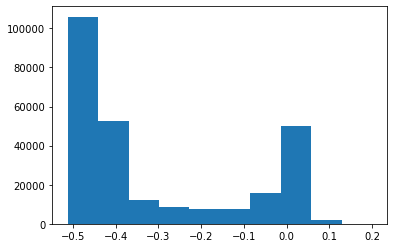

In [139]:
plt.hist(img.flatten())

(array([256954.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   5190.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

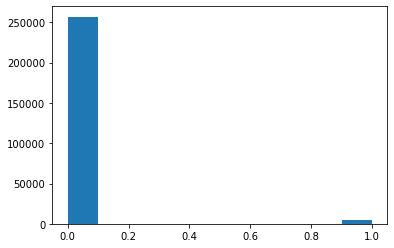

In [140]:
plt.hist(label.flatten())

In [141]:
ids = "10004O"
data_dir = "/home/jtabalon/airway_seg_data"
img_dir = os.path.join(data_dir, r'train/ct/ct_patient' + str(ids) + '.nii')
img_dir


'/home/jtabalon/airway_seg_data/train/ct/ct_patient10004O.nii'

In [142]:
mask_dir = os.path.join(data_dir, r'train/labels/aw_' + str(ids) + '.nii')
mask_dir

'/home/jtabalon/airway_seg_data/train/labels/aw_10004O.nii'

# Data Generator

In [143]:
# TODO: Create Data Generator
ids = "10004O"
data_dir = "/home/jtabalon/airway_seg_data"

def data_generator(ids, data_dir, batch_size=1, shuffle=True):
    # while True:
    #     if shuffle:
    #         np.random.shuffle(ids)
    #     num_batches = len(id) / batch_size

    # Let's just focus on doing one thing first
    img_dir = os.path.join(data_dir, r'train/ct/ct_patient' + str(ids) + '.nii')
    mask_dir = os.path.join(data_dir, r'train/labels/aw_' + str(ids) + '.nii')

    img = nib.load(img_dir).get_fdata() / 2000.
    mask = nib.load(mask_dir).get_fdata() / 2000.

    
    # Randomly choose value between (32) and (662 - 32)




    # if voxel = airway, extract 64x64x64 patch.


    # dims: ()

    

    # np.sum(test_mask, axis=(0,1,2,4))






#         # yield X,y





    


# Model Creation

In [144]:
nb_enc_features = [32, 64, 64, 64]
nb_dec_features = [64, 64, 64, 64, 64, 32, 32]

In [145]:
# Hyperparameters

batch_size = 1  # from torch notebook
# learning_rate = 1e-2 # TODO change learning rate
learning_rate = 1e-5 # TODO change learning rate

In [146]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [147]:

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras import Input


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    print(pool1)
    conv2 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    print(pool2)
    conv3 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    print(pool3)
    conv4 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(drop4)
    print(pool4)

    conv5 = Conv3D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv3D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv3D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = -1)
    conv6 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv3D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv3D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = -1)
    conv7 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv3D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = -1)
    conv8 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv3D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = -1)
    conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv3D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv3D(1, 1, activation = 'sigmoid')(conv9)

    #model = Model(input = inputs, output = conv10)
    model = Model(inputs, conv10)
    
    # if(pretrained_weights):
    	# model.load_weights(pretrained_weights)

    return model

In [148]:
# We'll leave the default branch of the git repo as a dice_loss for now until we get actually training.
def dice_loss(y_true, y_pred):
    # y_true = tf.cast(y_true, tf.float32) note: can delete
    # y_pred = tf.math.sigmoid(y_pred) #is this necessary? note: can delete
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / denominator

In [149]:
def compile_model(learning_rate):
    model.compile(optimizer = Adam(lr=learning_rate), loss = dice_loss)

Next steps: 
- create data generator

In [150]:
model = unet(input_size=(64,64,64, 1))
compile_model(learning_rate)

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 32, 64), dtype=tf.float32, name=None), name='max_pooling3d_12/MaxPool3D:0', description="created by layer 'max_pooling3d_12'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 16, 128), dtype=tf.float32, name=None), name='max_pooling3d_13/MaxPool3D:0', description="created by layer 'max_pooling3d_13'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 8, 256), dtype=tf.float32, name=None), name='max_pooling3d_14/MaxPool3D:0', description="created by layer 'max_pooling3d_14'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 4, 512), dtype=tf.float32, name=None), name='max_pooling3d_15/MaxPool3D:0', description="created by layer 'max_pooling3d_15'")


In [151]:
for layer in model.layers:
    print(layer.output_shape)

[(None, 64, 64, 64, 1)]
(None, 64, 64, 64, 64)
(None, 64, 64, 64, 64)
(None, 32, 32, 32, 64)
(None, 32, 32, 32, 128)
(None, 32, 32, 32, 128)
(None, 16, 16, 16, 128)
(None, 16, 16, 16, 256)
(None, 16, 16, 16, 256)
(None, 8, 8, 8, 256)
(None, 8, 8, 8, 512)
(None, 8, 8, 8, 512)
(None, 8, 8, 8, 512)
(None, 4, 4, 4, 512)
(None, 4, 4, 4, 1024)
(None, 4, 4, 4, 1024)
(None, 4, 4, 4, 1024)
(None, 8, 8, 8, 1024)
(None, 8, 8, 8, 512)
(None, 8, 8, 8, 1024)
(None, 8, 8, 8, 512)
(None, 8, 8, 8, 512)
(None, 16, 16, 16, 512)
(None, 16, 16, 16, 256)
(None, 16, 16, 16, 512)
(None, 16, 16, 16, 256)
(None, 16, 16, 16, 256)
(None, 32, 32, 32, 256)
(None, 32, 32, 32, 128)
(None, 32, 32, 32, 256)
(None, 32, 32, 32, 128)
(None, 32, 32, 32, 128)
(None, 64, 64, 64, 128)
(None, 64, 64, 64, 64)
(None, 64, 64, 64, 128)
(None, 64, 64, 64, 64)
(None, 64, 64, 64, 64)
(None, 64, 64, 64, 2)
(None, 64, 64, 64, 1)


In [152]:
model.input

<KerasTensor: shape=(None, 64, 64, 64, 1) dtype=float32 (created by layer 'input_4')>

In [153]:
model.output

<KerasTensor: shape=(None, 64, 64, 64, 1) dtype=float32 (created by layer 'conv3d_95')>

In [154]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 64,  0                                            
__________________________________________________________________________________________________
conv3d_72 (Conv3D)              (None, 64, 64, 64, 6 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv3d_73 (Conv3D)              (None, 64, 64, 64, 6 110656      conv3d_72[0][0]                  
__________________________________________________________________________________________________
max_pooling3d_12 (MaxPooling3D) (None, 32, 32, 32, 6 0           conv3d_73[0][0]                  
____________________________________________________________________________________________

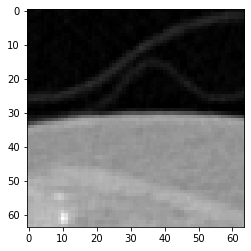

In [155]:
plt.imshow(test_img[:,(107-32):(107+32),(305-32):(305+32),(411-32):(411+32),:][0,:,:,32,0], cmap = "gray")

In [156]:
# test_image_slices = test_img[:,(107-32):(107+32),(305-32):(305+32),(411-32):(411+32),:][0,:,:,32,0]
# test_mask_slices = test_mask[:,(107-32):(107+32),(305-32):(305+32),(411-32):(411+32),:]

In [157]:
# real_test_image_slices = test_img[:,(291-32):(291+32),(170-32):(170+32),(411-32):(411+32),:] / 2000
# real_test_mask_slices = test_mask[:,(291-32):(291+32),(170-32):(170+32),(411-32):(411+32),:] 

In [158]:
# plt.hist(real_test_image_slices.flatten())

In [159]:
# plt.hist(real_test_mask_slices.flatten())

When training with image -> divide by 2000

In [160]:
# plt.hist(test_image_slices.flatten())

# TODO: Scale this: divide by 2000 

# Hounsfield unit are -2000-2000 so it's a nice number

In [161]:
# plt.hist(test_mask_slices.flatten())

# TODO: Find patch of mask with airway voxels. 

In [162]:
#model.fit(x=test_img, y=test_mask)
# model.fit(x=test_img[:,(107-32):(107+32),(305-32):(305+32),(411-32):(411+32),:], y=test_mask[:,(107-32):(107+32),(305-32):(305+32),(411-32):(411+32),:], epochs=100 ) # this is wrong lmao
model.fit(x=img, y=label, epochs=1000 )

# TODO: add model checkpoint callback

Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 0.9627
Epoch 2/1000
1/1 [==============================] - 0s 288ms/step - loss: 0.9610
Epoch 3/1000
1/1 [==============================] - 0s 291ms/step - loss: 0.9589
Epoch 4/1000
1/1 [==============================] - 0s 289ms/step - loss: 0.9560
Epoch 5/1000
1/1 [==============================] - 0s 291ms/step - loss: 0.9513
Epoch 6/1000
1/1 [==============================] - 0s 291ms/step - loss: 0.9449
Epoch 7/1000
1/1 [==============================] - 0s 290ms/step - loss: 0.9383
Epoch 8/1000
1/1 [==============================] - 0s 290ms/step - loss: 0.9301
Epoch 9/1000
1/1 [==============================] - 0s 291ms/step - loss: 0.9218
Epoch 10/1000
1/1 [==============================] - 0s 291ms/step - loss: 0.9083
Epoch 11/1000
1/1 [==============================] - 0s 291ms/step - loss: 0.9033
Epoch 12/1000
1/1 [==============================] - 0s 290ms/step - loss: 0.8787
Epoch 13/1000
1/1 [=========

In [163]:
# TODO configure prediction section
prediction = model.predict(real_test_image_slices)

In [174]:
np.argmax(np.sum(prediction[0,:,:,:,0]))

0

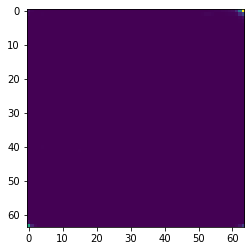

In [175]:
plt.imshow(prediction[0,:,:,0,0])

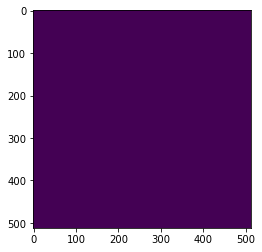

In [176]:
plt.imshow(test_mask[0,:,:,32,0])

In [166]:
# plt.imshow(test_predict[(107-32):(107+32),(305-32):(305+32),(411-32):(411+32)])